# Paper Reproduction Notebook

---

Author: ZHANG, Yiling  
Date: 27/10 - 3/11   
Paper: [A pan-cancer single-cell transcriptional atlas of tumor infiltrating myeloid cells, Cheng,Sijin et al.,Cell,2021](https://www.cell.com/cell/fulltext/S0092-8674(21)00010-6#secsectitle0075)

---

**Notes**   

This notebook is about the processing procedure for paper reproduction, other report and files please refer to:  

* Report: [GitBook - Report](https://hiiiyilingzhang.gitbook.io/panmyeloid-assignment/)
* Data Exploration Notebook: [GitBook - Data Exploration Notebook](https://hiiiyilingzhang.gitbook.io/panmyeloid-assignment/paper-reproduction-notebook)
* Source Code: [GitHub-hiiiyilingzhang/PanMyeloid-assignment](https://github.com/hiiiyilingzhang/PanMyeloid-assignment)
* TROUBLESHOOTING: [GitBook - TROUBLESHOOTING](https://hiiiyilingzhang.gitbook.io/panmyeloid-assignment/troubleshooting)

---

## 1. Environment Setting

In [53]:
import os
print (os.getcwd())

/home/data/vip8t02/Project/PanMyeloid-assignment/report


In [54]:
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

In [55]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
%matplotlib inline

sc.settings.verbosity = 3    # errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)
sc.logging.print_versions()

scanpy==1.4.3 anndata==0.7.6 umap==0.3.9 numpy==1.21.2 scipy==1.7.1 pandas==1.3.3 scikit-learn==0.24.2 statsmodels==0.13.0 python-igraph==0.9.7 


## 2. Load CRC Dataset

>**Finished QC in R**:  
>
>For other collected scRNA-seq datasets, we applied the same filtering steps to 10X Genomics datasets (CRC, KIDNEY, STAD, CRC, HCC, NPC and PAAD).

* Collected Datasets
    - Tumors, adjacent normal tissues and blood of 18 treatment-naive CRC patients
    - Stained with antibodies against CD45 for FACS sorting
    - 8 patient --> 10x Chromium Single cell 3' Library
    - 10 patient --> SMART-seq2 platform
    - Illumina Hiseq 4000 sequencer with 150-bp paired-end reads
    - Aligned and quantified using the Cell Ranger against GRCh38

### 2.1 Convert to Scanpy Object

In [127]:
CRC_ann = sc.read_h5ad("../processedData/CRC.processsed/CRC-myeloid-filtered.h5ad")
CRC_ann

AnnData object with n_obs × n_vars = 13795 × 15820
    obs: 'n_counts', 'n_genes', 'cancer', 'patient', 'tissue', 'tech', 'tech_10X', 'percent_mito', 'percent_hsp', 'MajorCluster', 'Sub_Cluster'
    var: 'features'

### 2.2 Normalization

>After quality control, we applied the library-size correction method to normalize the raw count by using `normalize_total` function in Scanpy. Then the logarithmized normalized count matrix was used for the downstream analysis.

Actually, there are two main approaches to normalize single cell data: 
1. One is a simple linear scaling to adjust counts such that each cell has about the same total library size. Examples include converting to counts per million (CPM) which does a reasonable job of correcting for differences in library size.

2. Another methods are more complex, and generally involve parametric modeling of count data to perform nonlinear normalization. These methods are useful when there are more complex sources of unwanted variation (e.g., for highly heterogeneous populations of cells with different sizes).

We usually just stick to the simple, but still need extract attention for some spectial situations. Here is a review [Cole,Michael B.et al.,
Cell Systems, 2019](https://www.cell.com/cell-systems/fulltext/S2405-4712(19)30080-8?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS2405471219300808%3Fshowall%3Dtrue#secsectitle0020) for the comparison of normalization methods.

In [72]:
# normalize with counts per million, excluding highly expressed genes from the size factor calculation.
sc.pp.normalize_per_cell(CRC_ann, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(CRC_ann)

## 3. Create one merged object

* Newly Generated Datasets (**Already weht through QC procedure and normalization**)
    - 10x Chromium Single cell 5' Library
    - Illumina Hiseq X Ten sequencer with 150-bp paired-end reads
    - Aligned and quantified using the Cell Ranger against GRCh38

### 3.1 Create Scanpy Object for newly generated datasets

In [73]:
PAAD = pd.read_csv("../rawData/PAAD/GSE154763_PAAD_normalized_expression.csv.gz", index_col=0)
cellinfo = pd.read_csv("../rawData/PAAD/GSE154763_PAAD_metadata.csv.gz", index_col=0)
geneinfo = pd.DataFrame(PAAD.columns,index=PAAD.columns,columns=['genes_index'])

PAAD_ann = sc.AnnData(PAAD, obs=cellinfo, var = geneinfo)
PAAD_ann

AnnData object with n_obs × n_vars = 2853 × 14140
    obs: 'percent_mito', 'n_counts', 'percent_hsp', 'barcode', 'batch', 'library_id', 'cancer', 'patient', 'tissue', 'n_genes', 'MajorCluster', 'source', 'tech', 'UMAP1', 'UMAP2'
    var: 'genes_index'

In [74]:
MYE = pd.read_csv("../rawData/MYE/GSE154763_MYE_normalized_expression.csv.gz", index_col=0)
cellinfo = pd.read_csv("../rawData/MYE/GSE154763_MYE_metadata.csv.gz", index_col=0)
geneinfo = pd.DataFrame(MYE.columns,index=MYE.columns,columns=['genes_index'])

MYE_ann = sc.AnnData(MYE, obs=cellinfo, var = geneinfo)
MYE_ann

AnnData object with n_obs × n_vars = 7619 × 15634
    obs: 'batch', 'patient', 'tissue', 'percent_hsp', 'percent_mito', 'n_genes', 'n_counts', 'MajorCluster', 'source', 'tech', 'cancer', 'UMAP1', 'UMAP2'
    var: 'genes_index'

In [75]:
ESCA = pd.read_csv("../rawData/ESCA/GSE154763_ESCA_normalized_expression.csv.gz", index_col=0)
cellinfo = pd.read_csv("../rawData/ESCA/GSE154763_ESCA_metadata.csv.gz", index_col=0)
geneinfo = pd.DataFrame(ESCA.columns,index=ESCA.columns,columns=['genes_index'])

ESCA_ann = sc.AnnData(ESCA, obs=cellinfo, var = geneinfo)
ESCA_ann

AnnData object with n_obs × n_vars = 7673 × 15550
    obs: 'percent_mito', 'n_counts', 'percent_hsp', 'barcode', 'batch', 'library_id', 'cancer', 'patient', 'tissue', 'n_genes', 'MajorCluster', 'source', 'tech', 'UMAP1', 'UMAP2'
    var: 'genes_index'

In [76]:
UCEC = pd.read_csv("../rawData/UCEC/GSE154763_UCEC_normalized_expression.csv.gz", index_col=0)
cellinfo = pd.read_csv("../rawData/UCEC/GSE154763_UCEC_metadata.csv.gz", index_col=0)
geneinfo = pd.DataFrame(UCEC.columns,index=UCEC.columns,columns=['genes_index'])

UCEC_ann = sc.AnnData(UCEC, obs=cellinfo, var = geneinfo)
UCEC_ann

AnnData object with n_obs × n_vars = 8808 × 15849
    obs: 'percent_mito', 'n_counts', 'percent_hsp', 'barcode', 'batch', 'library_id', 'cancer', 'patient', 'tissue', 'n_genes', 'MajorCluster', 'source', 'tech', 'UMAP1', 'UMAP2'
    var: 'genes_index'

In [77]:
OVFTC = pd.read_csv("../rawData/OV-FTC/GSE154763_OV-FTC_normalized_expression.csv.gz", index_col=0)
cellinfo = pd.read_csv("../rawData/OV-FTC/GSE154763_OV-FTC_metadata.csv.gz", index_col=0)
geneinfo = pd.DataFrame(OVFTC.columns,index=OVFTC.columns,columns=['genes_index'])

OVFTC_ann = sc.AnnData(OVFTC, obs=cellinfo, var = geneinfo)
OVFTC_ann

AnnData object with n_obs × n_vars = 3888 × 14008
    obs: 'percent_mito', 'n_counts', 'percent_hsp', 'barcode', 'batch', 'library_id', 'cancer', 'patient', 'tissue', 'n_genes', 'MajorCluster', 'source', 'tech', 'UMAP1', 'UMAP2'
    var: 'genes_index'

In [78]:
LYM = pd.read_csv("../rawData/LYM/GSE154763_LYM_normalized_expression.csv.gz", index_col=0)
cellinfo = pd.read_csv("../rawData/LYM/GSE154763_LYM_metadata.csv.gz", index_col=0)
geneinfo = pd.DataFrame(LYM.columns,index=LYM.columns,columns=['genes_index'])

LYM_ann = sc.AnnData(LYM, obs=cellinfo, var = geneinfo)
LYM_ann

AnnData object with n_obs × n_vars = 615 × 11283
    obs: 'batch', 'patient', 'tissue', 'percent_hsp', 'percent_mito', 'n_genes', 'n_counts', 'MajorCluster', 'source', 'tech', 'cancer', 'UMAP1', 'UMAP2'
    var: 'genes_index'

### 3.2 Merge and Examine Data

In [182]:
newdata = LYM_ann.concatenate(PAAD_ann,OVFTC_ann,UCEC_ann,ESCA_ann,MYE_ann)
print(newdata.obs['cancer'].value_counts())

UCEC      8808
ESCA      7673
MYE       7619
OV-FTC    3888
PAAD      2853
LYM        615
Name: cancer, dtype: int64


In [183]:
newdata.obs.drop(columns=['source','UMAP1','UMAP2','batch','library_id','barcode'],inplace = True)
newdata.obs['tech_10X']="10X5"
newdata.obs['MajorCluster2']="tmp"
newdata.obs['tech']="10X"

In [184]:
import re

def defineMajor(x):
    if bool(re.search("pDC",x)):
        return "pDC"
    elif bool(re.search("cDC",x)):
        return "cDC"
    elif bool(re.search("Macro|Mono|TAM",x)):
        return "Mono/Macro"
    elif bool(re.search("Mast",x)):
        return "Mast"

In [185]:
for index in range(newdata.obs.shape[0]):
    newdata.obs.iloc[index,10] = defineMajor(newdata.obs.iloc[index,6])

In [186]:
newdata.obs.rename(columns={'MajorCluster':'Sub_Cluster','MajorCluster2':'MajorCluster'},inplace=True)
newdata.obs

patient tissue  percent_hsp  percent_mito  n_genes  \
index                                                                         
AACACGTGTTTGGGCC-15-0  P20181123      T     0.006040      0.000000     4789   
AACCGCGAGTTCGCAT-15-0  P20181123      T     0.003356      0.000000     1641   
AACTGGTAGCCACTAT-15-0  P20181123      T     0.000368      0.000000      922   
AAGGCAGTCGTCGTTC-15-0  P20181123      T     0.004203      0.000000     1511   
AAGGTTCAGATAGGAG-15-0  P20181123      T     0.016225      0.000000     1350   
...                          ...    ...          ...           ...      ...   
TTTATGCGTCGAGATG-25-5  P20190322      T     0.003601      0.031445     1316   
TTTATGCGTGAGGGTT-25-5  P20190322      T     0.004241      0.032207     1930   
TTTCCTCCAAGCCTAT-25-5  P20190322      T     0.009058      0.042044     1821   
TTTCCTCGTGGACGAT-25-5  P20190322      T     0.003082      0.053721     1056   
TTTGTCAAGTCACGCC-25-5  P20190322      T     0.007208      0.026855     2857   

                       n_counts      Sub_Cluster tech cancer tech_10X  \
index                                                                   
AACACGTGTTTGGGCC-15-0   29802.0  M02_cDC1_CLEC9A  10X    LYM     10X5   
AACCGCGAGTTCGCAT-15-0    5065.0  M06_Macro_ISG15  10X    LYM     10X5   
AACTGGTAGCCACTAT-15-0    2716.0  M06_Macro_ISG15  10X    LYM     10X5   
AAGGCAGTCGTCGTTC-15-0    4759.0  M06_Macro_ISG15  10X    LYM     10X5   
AAGGTTCAGATAGGAG-15-0    3698.0    M03_cDC2_CD1C  10X    LYM     10X5   
...                         ...              ...  ...    ...      ...   
TTTATGCGTCGAGATG-25-5    4166.0   M09_Macro_C1QC  10X    MYE     10X5   
TTTATGCGTGAGGGTT-25-5    7545.0   M09_Macro_C1QC  10X    MYE     10X5   
TTTCCTCCAAGCCTAT-25-5    5851.0   M09_Macro_C1QC  10X    MYE     10X5   
TTTCCTCGTGGACGAT-25-5    2271.0   M09_Macro_C1QC  10X    MYE     10X5   
TTTGTCAAGTCACGCC-25-5   14150.0   M09_Macro_C1QC  10X    MYE     10X5   

                      MajorCluster  
index                               
AACACGTGTTTGGGCC-15-0          cDC  
AACCGCGAGTTCGCAT-15-0   Mono/Macro  
AACTGGTAGCCACTAT-15-0   Mono/Macro  
AAGGCAGTCGTCGTTC-15-0   Mono/Macro  
AAGGTTCAGATAGGAG-15-0          cDC  
...                            ...  
TTTATGCGTCGAGATG-25-5   Mono/Macro  
TTTATGCGTGAGGGTT-25-5   Mono/Macro  
TTTCCTCCAAGCCTAT-25-5   Mono/Macro  
TTTCCTCGTGGACGAT-25-5   Mono/Macro  
TTTGTCAAGTCACGCC-25-5   Mono/Macro  

[31456 rows x 11 columns]

In [187]:
print(newdata.obs['MajorCluster'].value_counts())

Mono/Macro    25833
cDC            3344
Mast           1829
pDC             450
Name: MajorCluster, dtype: int64


In [188]:
newdata.write("../processedData/alldata.obj/newly-generated-data-fixed-obs.h5ad")

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'Sub_Cluster' as categorical
... storing 'tech' as categorical
... storing 'cancer' as categorical
... storing 'tech_10X' as categorical
... storing 'MajorCluster' as categorical


In [203]:
# merge into one object.
alldata = newdata.concatenate(CRC_ann)
print(alldata.obs['cancer'].value_counts())

CRC       13795
UCEC       8808
ESCA       7673
MYE        7619
OV-FTC     3888
PAAD       2853
LYM         615
Name: cancer, dtype: int64


In [190]:
alldata.obs

patient tissue  percent_hsp  percent_mito  n_genes  \
AACACGTGTTTGGGCC-15-0-0  P20181123      T     0.006040      0.000000     4789   
AACCGCGAGTTCGCAT-15-0-0  P20181123      T     0.003356      0.000000     1641   
AACTGGTAGCCACTAT-15-0-0  P20181123      T     0.000368      0.000000      922   
AAGGCAGTCGTCGTTC-15-0-0  P20181123      T     0.004203      0.000000     1511   
AAGGTTCAGATAGGAG-15-0-0  P20181123      T     0.016225      0.000000     1350   
...                            ...    ...          ...           ...      ...   
P_T_P1228_10676-1            P1228      T     0.335713      0.591267     4506   
P_T_P1228_10778-1            P1228      T     0.544217      0.959686     4321   
P_T_P1228_10784-1            P1228      T     0.451440      0.732953     4577   
P_T_P1228_10799-1            P1228      T     0.482179      0.742669     4065   
P_T_P1228_10800-1            P1228      T     0.816831      0.950539     4574   

                             n_counts      Sub_Cluster        tech cancer  \
AACACGTGTTTGGGCC-15-0-0  29802.000000  M02_cDC1_CLEC9A         10X    LYM   
AACCGCGAGTTCGCAT-15-0-0   5065.000000  M06_Macro_ISG15         10X    LYM   
AACTGGTAGCCACTAT-15-0-0   2716.000000  M06_Macro_ISG15         10X    LYM   
AAGGCAGTCGTCGTTC-15-0-0   4759.000000  M06_Macro_ISG15         10X    LYM   
AAGGTTCAGATAGGAG-15-0-0   3698.000000    M03_cDC2_CD1C         10X    LYM   
...                               ...              ...         ...    ...   
P_T_P1228_10676-1        16373.216968        Mono-CD14  Smart-seq2    CRC   
P_T_P1228_10778-1        14662.114240      Mast-TPSAB1  Smart-seq2    CRC   
P_T_P1228_10784-1        17858.945581         TAM-C1QC  Smart-seq2    CRC   
P_T_P1228_10799-1        15981.777171         TAM-C1QC  Smart-seq2    CRC   
P_T_P1228_10800-1        14047.981586         TAM-C1QC  Smart-seq2    CRC   

                          tech_10X MajorCluster batch  
AACACGTGTTTGGGCC-15-0-0       10X5          cDC     0  
AACCGCGAGTTCGCAT-15-0-0       10X5   Mono/Macro     0  
AACTGGTAGCCACTAT-15-0-0       10X5   Mono/Macro     0  
AAGGCAGTCGTCGTTC-15-0-0       10X5   Mono/Macro     0  
AAGGTTCAGATAGGAG-15-0-0       10X5          cDC     0  
...                            ...          ...   ...  
P_T_P1228_10676-1        SmartSeq2   Mono/Macro     1  
P_T_P1228_10778-1        SmartSeq2         Mast     1  
P_T_P1228_10784-1        SmartSeq2   Mono/Macro     1  
P_T_P1228_10799-1        SmartSeq2   Mono/Macro     1  
P_T_P1228_10800-1        SmartSeq2   Mono/Macro     1  

[45251 rows x 12 columns]

* Regress out covariates

> Then, effects of the total count per cell, the percentage of mitochondrial gene count and the percentage of count for heat shock protein associated genes (HSP) were regressed out by using scanpy.pp.regress_out function.

This is achieved by doing a generalized linear regression using these parameters as covariates in the model. Then the residuals of the model are taken as the "regressed data".

In [205]:
# regress out unwanted variables
sc.pp.regress_out(alldata, ['n_counts', 'percent_mito','percent_hsp'])

regressing out ['n_counts', 'percent_mito', 'percent_hsp']
    finished (0:35:27.53)


In [206]:
alldata.write("../processedData/alldata.obj/regressed-alldata.h5ad")

In [207]:
alldata.obs.to_csv("../processedData/alldata.obj/alldata-metadata.csv",sep=',',index=True,header=True)

In [208]:
# Store the full matrix in the raw slot before doing variable gene selection
alldata.raw = alldata

## 4. Compute HVG and PCA&UMAP

#### 4.1.1 Compute HVG

We need to find genes that are highly variable across cells, which in turn will also provide a good separation of the cell clusters.

> In brief, 2,000 highly-variable genes were selected for downstream analysis by using scanpy.pp.highly_variable_genes function with parameter “n_top_genes=2000.”

If you pass `n_top_genes`, all cutoffs are ignored.
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes: 1999


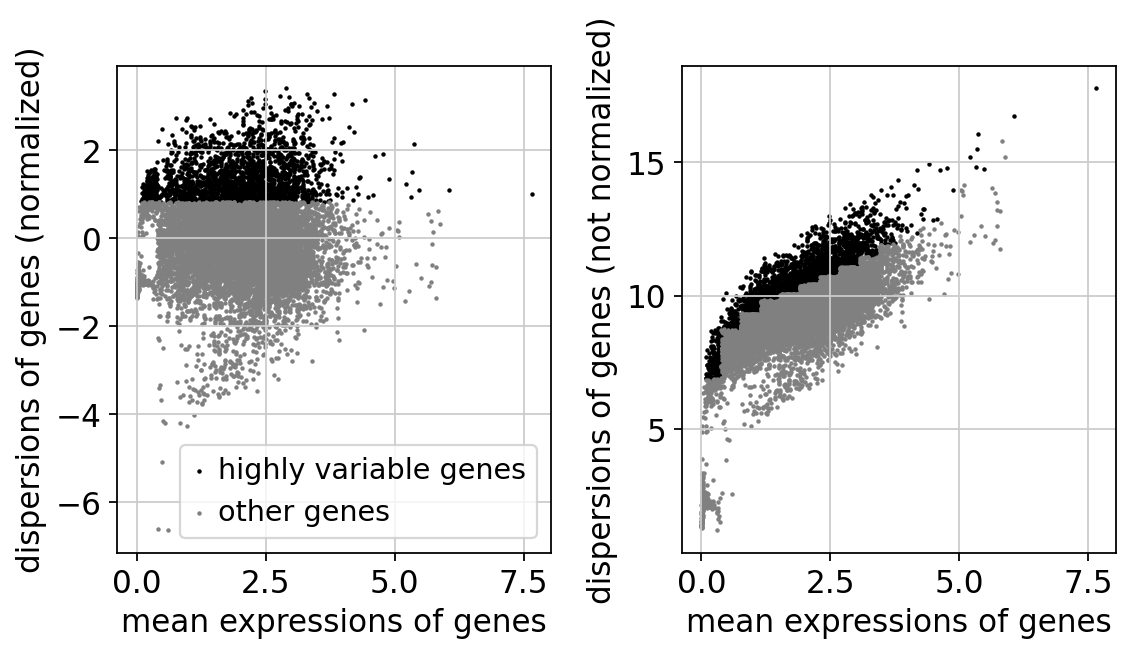

In [209]:
# compute variable genes
sc.pp.highly_variable_genes(alldata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=2000,flavor='seurat')
print("Highly variable genes: %d"%sum(alldata.var.highly_variable))

#plot variable genes
sc.pl.highly_variable_genes(alldata)

# subset for variable genes in the dataset
alldata = alldata[:, alldata.var['highly_variable']]

In [210]:
alldata.write("../processedData/alldata.obj/compute-HVG-alldata.h5ad")

#### 4.1.2 PCA & UMAP

>A principal component analysis (PCA) matrix with 100 components were calculated to reveal the main axes of variation and denoise the data by using scanpy.tl.pca function with parameter “svd_solver='arpack', n_comps=100. For visualization, the dimensionality of each dataset was further reduced using Uniform Manifold Approximation and Projection (UMAP) implemented in scanpy.tl.umap function with default parameters.

In [211]:
sc.tl.pca(alldata, svd_solver='arpack', n_comps=100)

computing PCA with n_comps = 100
computing PCA on highly variable genes
    finished (0:00:15.48)


In [212]:
sc.pp.neighbors(alldata, n_pcs=100)
sc.tl.umap(alldata)

computing neighbors
    using 'X_pca' with n_pcs = 100


/home/data/vip8t02/anaconda3/envs/scanpy-1.4.3/lib/python3.9/site-packages/scanpy/neighbors/__init__.py:88: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:  # we shouldn't need this here...


    finished (0:00:23.30) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    using 'X_pca' with n_pcs = 100
    finished (0:00:29.84) --> added
    'X_umap', UMAP coordinates (adata.obsm)


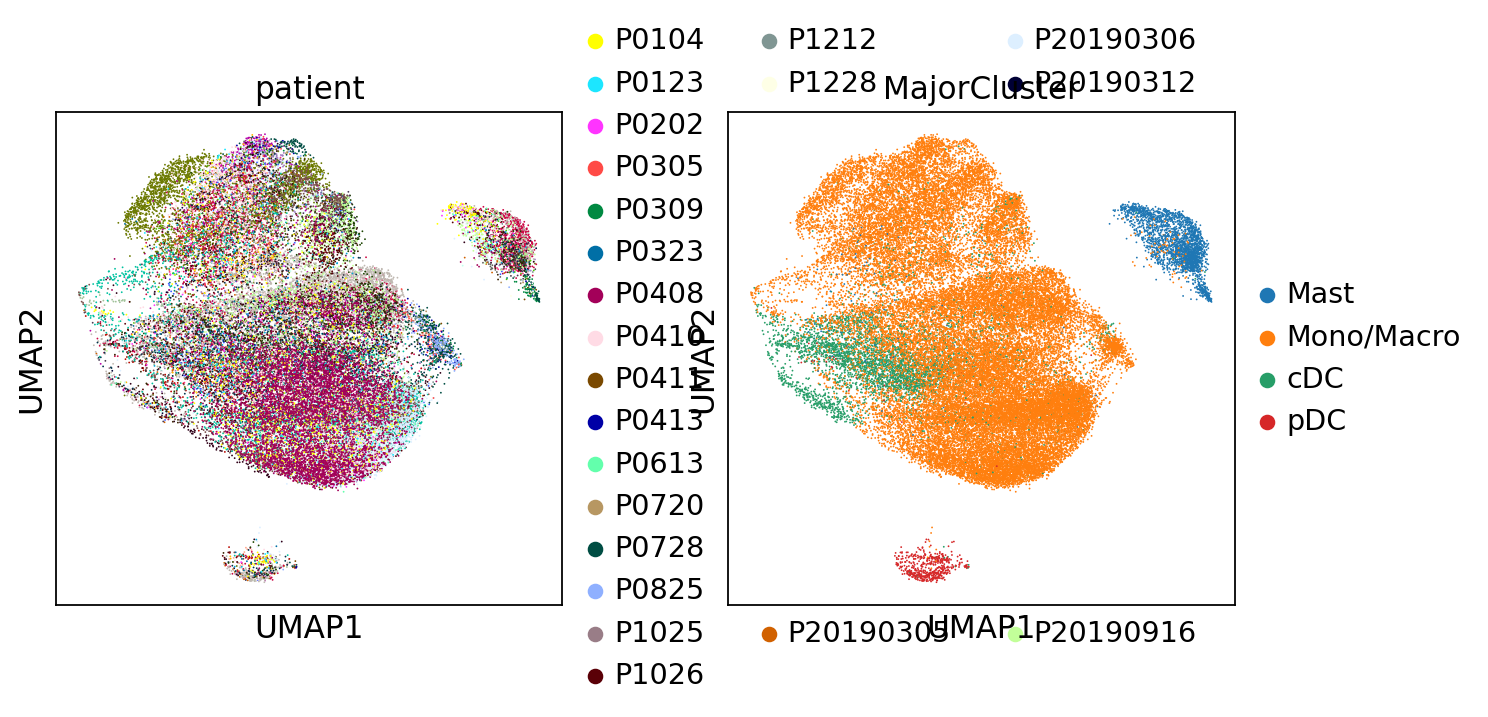

In [213]:
sc.pl.umap(alldata, color=['patient','MajorCluster'])

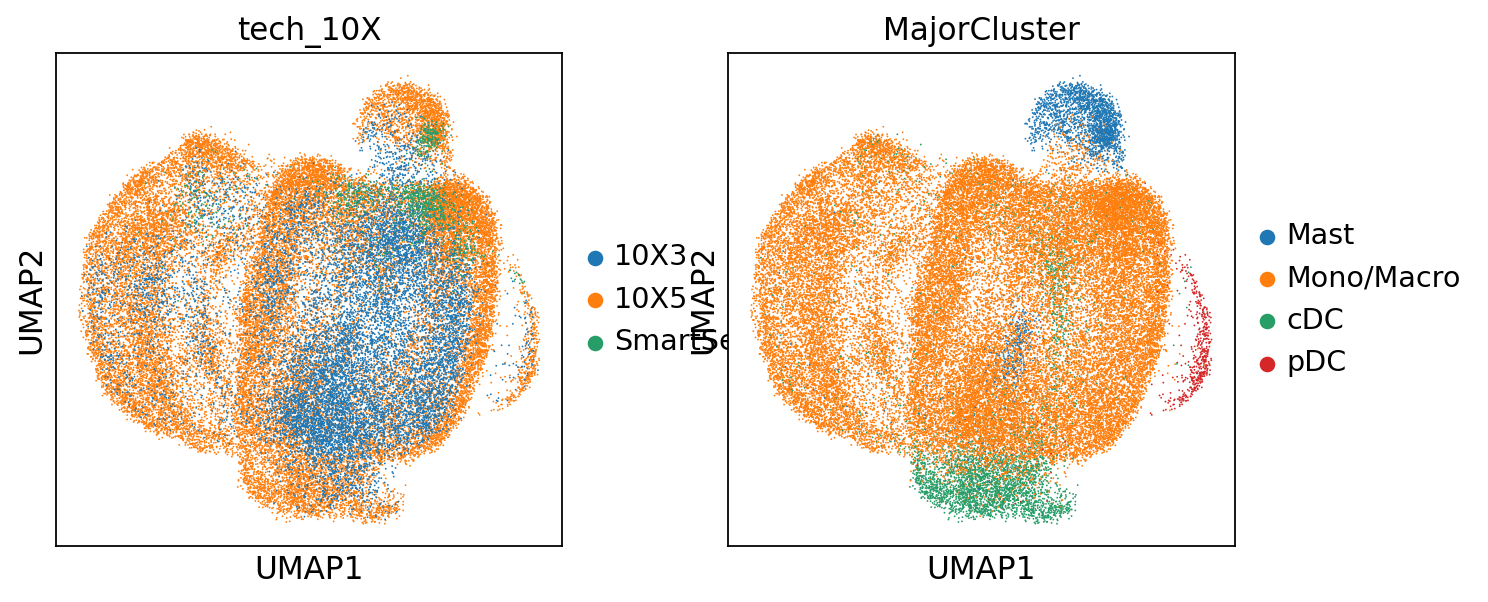

In [342]:
sc.pl.umap(alldata, color=['tech_10X','MajorCluster'])

## 4. Batches Removal

### 4.1  Remove Batches from Donors

> To remove the batch effects from different donors, we applied bbknn algorithm with parameter “batch_key='patient', n_pcs=100” to obtain a batch-corrected space.

In [214]:
import bbknn 
bbknn.bbknn(alldata, batch_key='patient',n_pcs=100)

computing batch balanced neighbors
	finished (0:00:46.19) --> added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix


* Check the batch effect after bbknn

computing UMAP
    using 'X_pca' with n_pcs = 100
    finished (0:01:02.50) --> added
    'X_umap', UMAP coordinates (adata.obsm)


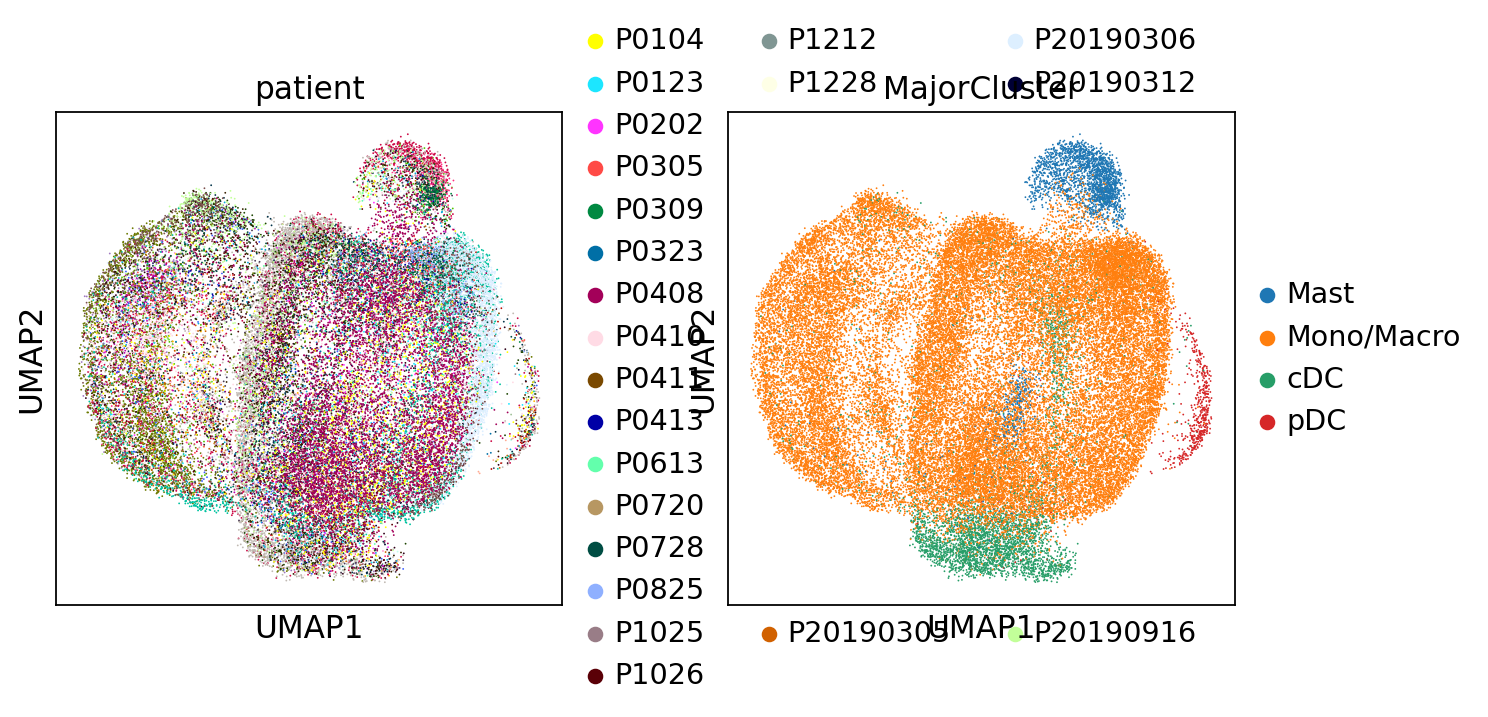

In [215]:
sc.tl.umap(alldata)
sc.pl.umap(alldata, color=['patient','MajorCluster'])

### 4.2  Remove Batches from Platforms

> We run two rounds of Scanorama (Hie et al., 2019), an algorithm that could identify and merge shared cell types among multiple datasets, to remove the batch effects within scRNA-seq datasets of 15 cancer types. First, we applied Scanorama to datasets generated from 3′ library and 5′ library from 10x Genomics to remove the batch effects attribute to these two protocols. Then, a second-round of Scanorama was applied to remove the batch effects resulting from the diverse platforms, including 10x Genomics, MARS-Seq and inDrop. 


Create individual AnnData objects from each of the datasets.

In [303]:
alldata2 = alldata.raw.to_adata() 

In [304]:
# split per batch based on tech
batches = alldata.obs['tech'].cat.categories.tolist()
data_tech = {}
for batch in batches:
    data_tech[batch] = alldata2[alldata2.obs['tech'] == batch,]

data_tech

{'10X': View of AnnData object with n_obs × n_vars = 44019 × 10390
     obs: 'patient', 'tissue', 'percent_hsp', 'percent_mito', 'n_genes', 'n_counts', 'Sub_Cluster', 'tech', 'cancer', 'tech_10X', 'MajorCluster', 'batch'
     var: 'genes_index-0', 'features-1'
     uns: 'pca', 'neighbors', 'patient_colors', 'MajorCluster_colors'
     obsm: 'X_pca', 'X_umap',
 'Smart-seq2': View of AnnData object with n_obs × n_vars = 1232 × 10390
     obs: 'patient', 'tissue', 'percent_hsp', 'percent_mito', 'n_genes', 'n_counts', 'Sub_Cluster', 'tech', 'cancer', 'tech_10X', 'MajorCluster', 'batch'
     var: 'genes_index-0', 'features-1'
     uns: 'pca', 'neighbors', 'patient_colors', 'MajorCluster_colors'
     obsm: 'X_pca', 'X_umap'}

In [305]:
# split per batch into 10X objects.
batches = alldata.obs['tech_10X'].cat.categories.tolist()
del batches[2]
data_10X = {}
for batch in batches:
    data_10X[batch] = alldata2[alldata2.obs['tech_10X'] == batch,]

data_10X

{'10X3': View of AnnData object with n_obs × n_vars = 12563 × 10390
     obs: 'patient', 'tissue', 'percent_hsp', 'percent_mito', 'n_genes', 'n_counts', 'Sub_Cluster', 'tech', 'cancer', 'tech_10X', 'MajorCluster', 'batch'
     var: 'genes_index-0', 'features-1'
     uns: 'pca', 'neighbors', 'patient_colors', 'MajorCluster_colors'
     obsm: 'X_pca', 'X_umap',
 '10X5': View of AnnData object with n_obs × n_vars = 31456 × 10390
     obs: 'patient', 'tissue', 'percent_hsp', 'percent_mito', 'n_genes', 'n_counts', 'Sub_Cluster', 'tech', 'cancer', 'tech_10X', 'MajorCluster', 'batch'
     var: 'genes_index-0', 'features-1'
     uns: 'pca', 'neighbors', 'patient_colors', 'MajorCluster_colors'
     obsm: 'X_pca', 'X_umap'}

In [306]:
data_10X_ann = alldata2[alldata2.obs["tech_10X"] != "SmartSeq2", :]
data_10X_ann

View of AnnData object with n_obs × n_vars = 44019 × 10390
    obs: 'patient', 'tissue', 'percent_hsp', 'percent_mito', 'n_genes', 'n_counts', 'Sub_Cluster', 'tech', 'cancer', 'tech_10X', 'MajorCluster', 'batch'
    var: 'genes_index-0', 'features-1'
    uns: 'pca', 'neighbors', 'patient_colors', 'MajorCluster_colors'
    obsm: 'X_pca', 'X_umap'

In [307]:
# split per batch into SmartSeq2 objects.
data_SS2 = {}
data_SS2['SmartSeq2'] = alldata2[alldata2.obs['tech_10X'] == 'SmartSeq2',]
data_SS2

{'SmartSeq2': View of AnnData object with n_obs × n_vars = 1232 × 10390
     obs: 'patient', 'tissue', 'percent_hsp', 'percent_mito', 'n_genes', 'n_counts', 'Sub_Cluster', 'tech', 'cancer', 'tech_10X', 'MajorCluster', 'batch'
     var: 'genes_index-0', 'features-1'
     uns: 'pca', 'neighbors', 'patient_colors', 'MajorCluster_colors'
     obsm: 'X_pca', 'X_umap'}

In [308]:
data_SS2_ann = alldata2[alldata2.obs["tech_10X"] == "SmartSeq2", :]
data_SS2_ann

View of AnnData object with n_obs × n_vars = 1232 × 10390
    obs: 'patient', 'tissue', 'percent_hsp', 'percent_mito', 'n_genes', 'n_counts', 'Sub_Cluster', 'tech', 'cancer', 'tech_10X', 'MajorCluster', 'batch'
    var: 'genes_index-0', 'features-1'
    uns: 'pca', 'neighbors', 'patient_colors', 'MajorCluster_colors'
    obsm: 'X_pca', 'X_umap'

#### 4.2.1 **ROUND 1**: 3′ library and 5′ library

Detect HVG

In [311]:
# data_10X_ann2 = data_10X_ann.raw.to_adata() 

# check that the matrix looks like noramlized counts
print(data_10X_ann.X[1:5,1:5])

[[-4.0733621e-02 -2.3683284e-01  1.1952481e+00 -7.0990114e-03]
 [ 3.0918663e-02 -1.9151421e-01 -2.9681513e-01  8.6839534e-03]
 [-3.1718317e-02 -2.3126537e-01 -4.1332448e-01 -5.1082806e-03]
 [ 1.3939840e+00 -2.1443358e-01 -3.6623287e-01  1.3139478e-03]]


In [312]:
var_genes_all = alldata.var.highly_variable
print("Highly variable genes: %d"%sum(var_genes_all))

# use batch_key to detect variable genes in each dataset separately
sc.pp.highly_variable_genes(data_10X_ann, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'tech_10X')
print("Highly variable genes intersection: %d"%sum(data_10X_ann.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(data_10X_ann.var.highly_variable_nbatches.value_counts())

var_genes_batch = data_10X_ann.var.highly_variable_nbatches > 0

Highly variable genes: 1999


Trying to set attribute `.var` of view, copying.


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes intersection: 272
Number of batches where gene is variable:
0    8896
1    1222
2     272
Name: highly_variable_nbatches, dtype: int64


Compare overlap of the variable genes.

In [313]:
print("Any batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d"%sum(data_10X_ann.var.highly_variable_nbatches == 2))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & data_10X_ann.var.highly_variable_intersection))

Any batch var genes: 1494
All data var genes: 1999
Overlap: 330
Variable genes in all batches: 272
Overlap batch instersection and all: 76


Select all genes that are variable in at least 1 datasets and use for remaining analysis.

In [315]:
var_select = data_10X_ann.var.highly_variable_nbatches >= 1
var_genes = var_select.index[var_select]
len(var_genes)

1494

run Scanorama

In [316]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import scanorama

data_10X2 = dict()
for ds in data_10X.keys():
    print(ds)
    data_10X2[ds] = data_10X[ds][:,var_genes]

#convert to list of AnnData objects
data_10X2_adatas = list(data_10X2.values())

# run scanorama.integrate
scanorama.integrate_scanpy(data_10X2_adatas, dimred = 100)

10X3
10X5
Found 1494 genes among all datasets
[[0.         0.52177028]
 [0.         0.        ]]
Processing datasets (0, 1)


In [317]:
#scanorama adds the corrected matrix to adata.obsm in each of the datasets in adatas.
data_10X2_adatas[0].obsm['X_scanorama'].shape

(12563, 100)

In [318]:
# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in data_10X2_adatas]

# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

# add to the AnnData object
data_10X_ann.obsm["Scanorama"] = all_s

(44019, 100)


In [319]:
# tsne and umap
sc.pp.neighbors(data_10X_ann, n_pcs =100, use_rep = "Scanorama")
sc.tl.umap(data_10X_ann)

computing neighbors


/home/data/vip8t02/anaconda3/envs/scanpy-1.4.3/lib/python3.9/site-packages/scanpy/neighbors/__init__.py:88: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:  # we shouldn't need this here...


    finished (0:00:12.26) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:31.61) --> added
    'X_umap', UMAP coordinates (adata.obsm)


<AxesSubplot:title={'center':'Scanorama ROUND1 umap'}, xlabel='UMAP1', ylabel='UMAP2'>

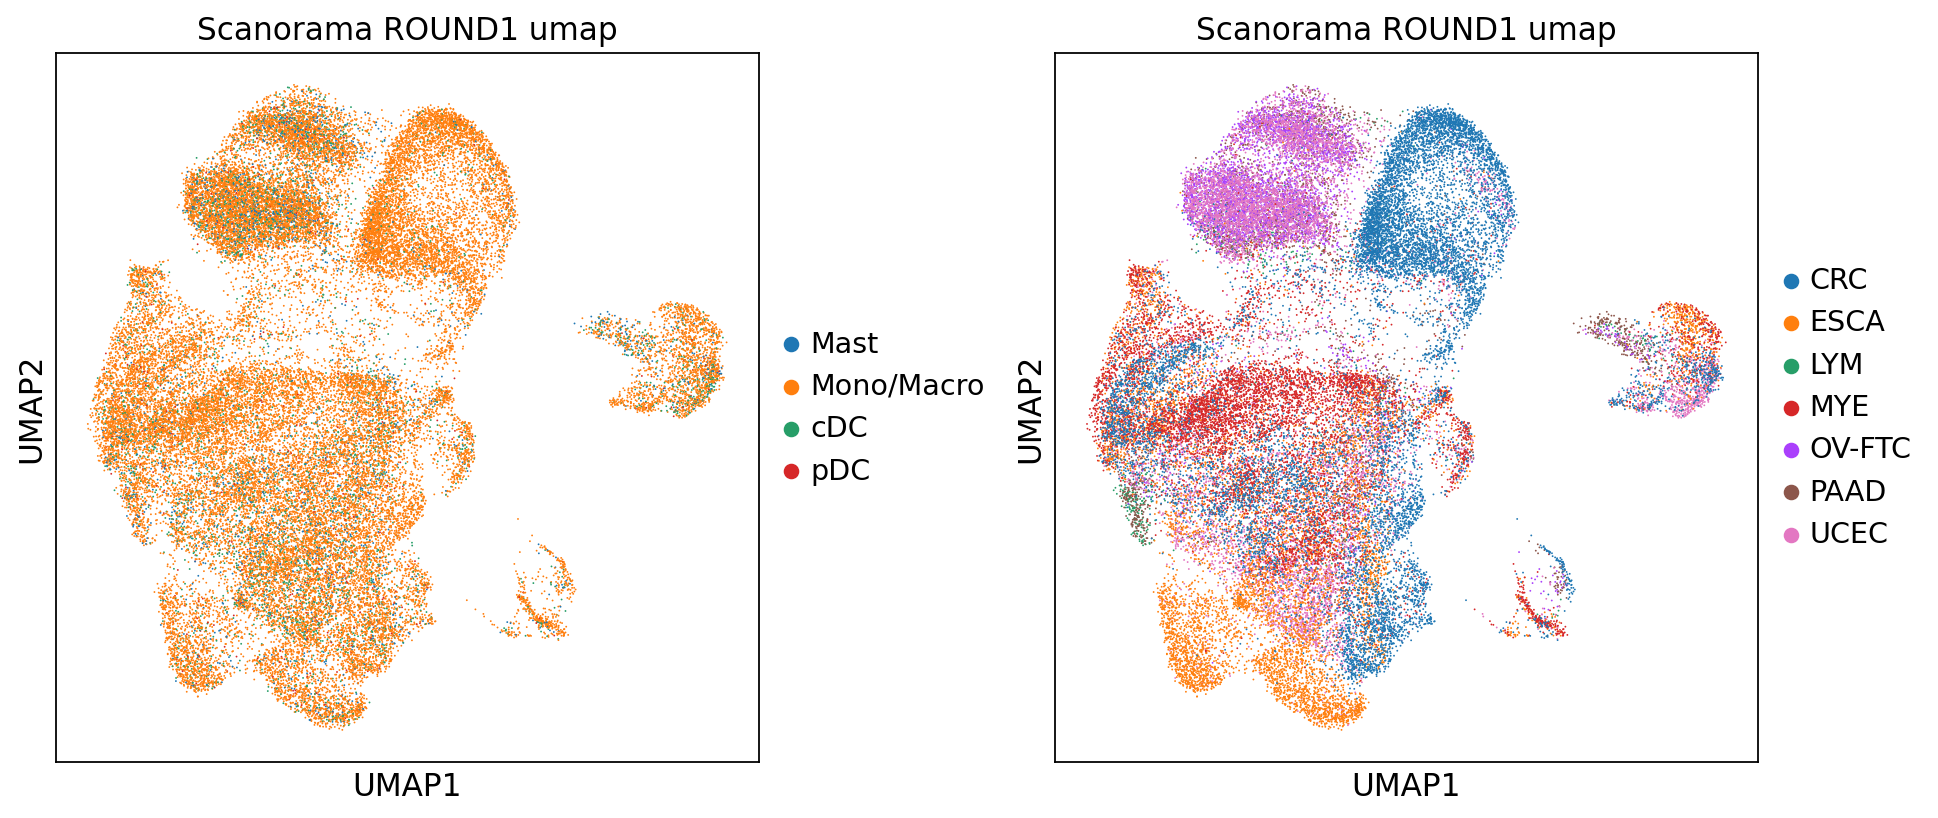

In [320]:
fig, axs = plt.subplots(1, 2, figsize=(12,5),constrained_layout=True)
sc.pl.umap(data_10X_ann, color="MajorCluster", title="Scanorama ROUND1 umap", ax=axs[0], show=False)
sc.pl.umap(data_10X_ann, color="cancer", title="Scanorama ROUND1 umap", ax=axs[1], show=False)

#### 4.2.2 **ROUND 2**: 10X and Smart Seq-2

In [322]:
# Merge data
techdata = data_10X_ann.concatenate(data_SS2_ann)
techdata

AnnData object with n_obs × n_vars = 45251 × 10390
    obs: 'patient', 'tissue', 'percent_hsp', 'percent_mito', 'n_genes', 'n_counts', 'Sub_Cluster', 'tech', 'cancer', 'tech_10X', 'MajorCluster', 'batch'
    var: 'genes_index-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0', 'features-1'
    obsm: 'X_pca', 'X_umap'

Detect HVG

In [324]:
# check that the matrix looks like noramlized counts
print(techdata.X[1:5,1:5])

[[-4.0733621e-02 -2.3683284e-01  1.1952481e+00 -7.0990114e-03]
 [ 3.0918663e-02 -1.9151421e-01 -2.9681513e-01  8.6839534e-03]
 [-3.1718317e-02 -2.3126537e-01 -4.1332448e-01 -5.1082806e-03]
 [ 1.3939840e+00 -2.1443358e-01 -3.6623287e-01  1.3139478e-03]]


In [325]:
var_genes_all = alldata.var.highly_variable
print("Highly variable genes: %d"%sum(var_genes_all))

# use batch_key to detect variable genes in each dataset separately
sc.pp.highly_variable_genes(techdata, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'tech')
print("Highly variable genes intersection: %d"%sum(techdata.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(techdata.var.highly_variable_nbatches.value_counts())

var_genes_batch = techdata.var.highly_variable_nbatches > 0

... storing 'patient' as categorical
... storing 'Sub_Cluster' as categorical
... storing 'tech' as categorical
... storing 'cancer' as categorical
... storing 'tech_10X' as categorical


Highly variable genes: 1999
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes intersection: 4
Number of batches where gene is variable:
0    9232
1    1154
2       4
Name: highly_variable_nbatches, dtype: int64


Compare overlap of the variable genes.

In [326]:
print("Any batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d"%sum(techdata.var.highly_variable_nbatches == 2))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & techdata.var.highly_variable_intersection))

Any batch var genes: 1158
All data var genes: 1999
Overlap: 337
Variable genes in all batches: 4
Overlap batch instersection and all: 3


Select all genes that are variable in at least 1 datasets and use for remaining analysis.

In [328]:
var_select = techdata.var.highly_variable_nbatches >= 1
var_genes = var_select.index[var_select]
len(var_genes)

1158

run Scanorama

In [329]:
techdata3 = dict()
for ds in data_tech.keys():
    print(ds)
    techdata3[ds] = data_tech[ds][:,var_genes]

#convert to list of AnnData objects
tech_adatas = list(techdata3.values())

# run scanorama.integrate
scanorama.integrate_scanpy(tech_adatas, dimred = 100)

10X
Smart-seq2
Found 1158 genes among all datasets
[[0.         0.94886364]
 [0.         0.        ]]
Processing datasets (0, 1)


In [330]:
#scanorama adds the corrected matrix to adata.obsm in each of the datasets in adatas.
tech_adatas[0].obsm['X_scanorama'].shape

(44019, 100)

In [331]:
# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in tech_adatas]

# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

# add to the AnnData object
techdata.obsm["Scanorama"] = all_s

(45251, 100)


In [332]:
# tsne and umap
sc.pp.neighbors(techdata, n_pcs =100, use_rep = "Scanorama")
sc.tl.umap(techdata)

computing neighbors


/home/data/vip8t02/anaconda3/envs/scanpy-1.4.3/lib/python3.9/site-packages/scanpy/neighbors/__init__.py:88: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:  # we shouldn't need this here...


    finished (0:00:12.92) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:27.35) --> added
    'X_umap', UMAP coordinates (adata.obsm)


<AxesSubplot:title={'center':'Scanorama ROUND2 umap'}, xlabel='UMAP1', ylabel='UMAP2'>

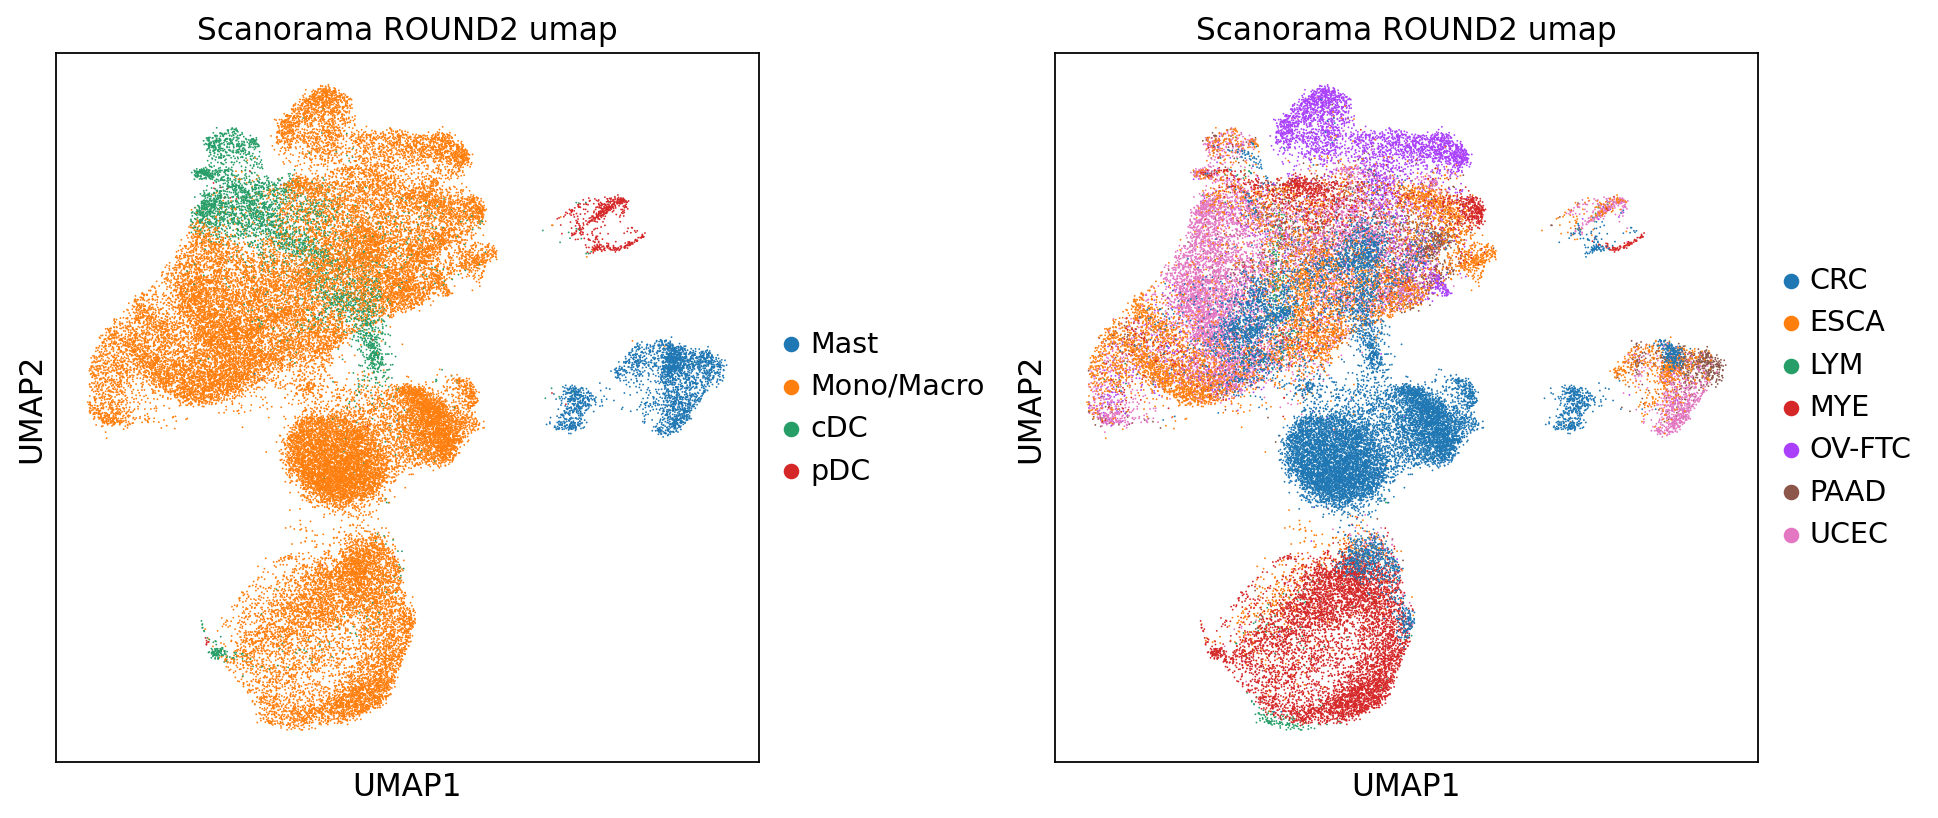

In [334]:
fig, axs = plt.subplots(1, 2, figsize=(12,5),constrained_layout=True)
sc.pl.umap(techdata, color="MajorCluster", title="Scanorama ROUND2 umap", ax=axs[0], show=False)
sc.pl.umap(techdata, color="cancer", title="Scanorama ROUND2 umap", ax=axs[1], show=False)

In [343]:
techdata.write("../processedData/alldata.obj/finish-integration-with-umap.h5ad")

## 5. Supplemental Information

* References  
    - [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/index.html)  
    - [Scanpy – Single-Cell Analysis in Python - readthedocs](https://scanpy.readthedocs.io/en/stable/index.html)  
    - [anndata - Annotated Data - readthedocs](https://anndata.readthedocs.io/en/stable/index.html)  
    - [NBISweden/workshop-scRNAseq](https://github.com/NBISweden/workshop-scRNAseq)

* System.info

In [336]:
import IPython
print(IPython.sys_info())

{'commit_hash': '24512bd29',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/home/data/vip8t02/anaconda3/envs/scanpy-1.4.3/lib/python3.9/site-packages/IPython',
 'ipython_version': '7.27.0',
 'os_name': 'posix',
 'platform': 'Linux-5.11.0-27-generic-x86_64-with-glibc2.31',
 'sys_executable': '/home/data/vip8t02/anaconda3/envs/scanpy-1.4.3/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.9.7 (default, Sep 16 2021, 13:09:58) \n[GCC 7.5.0]'}
